# Projet P6 - Classifiez automatiquement des biens de consommation
*OPENCLASSROOMS - Parcours Data Scientist - Adeline Le Ray - 05/2024*
<hr>

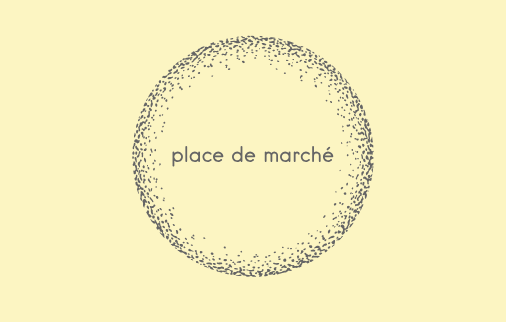

## <font color='#46abe6'>Contexte</font>

Sur place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle,  il devient nécessaire d'automatiser cette tâche d‘attribution de la catégorie.

La mission est de réaliser une étude de faisabilité d'un moteur de classification automatique d’articles, en utilisant leur image et leur description sur le jeu de données d'articles disponible.

Le présent notebook porte sur l'extraction des features texte avec l'approche word/sentence embedding avec BERT Hub Tensorflow et USE.

*(Exécution sous Google Colaboratory)*

## <font color='#46abe6'>Sommaire</font>

<span style='background:#46abe6'><span style='color:white'>**Partie 1 - Données textuelles - Analyse exploratoire des données**</span></span>

<span style='background:#d5155b'><span style='color:white'>**Partie 2 - Données textuelles - Feature extraction et faisabilité**</span></span>
* 2.1 - Etude de faisabilité de la classification à partir des données textuelles
* 2.2 - Features extraction des données textuelles BERT Huggingface
* 2.3 - Features extraction des données textuelles BERT Hub tensorflow + USE

<span style='background:#46abe6'><span style='color:white'>**Partie 3 - Images - Analyse exploratoire des données**</span></span>

<span style='background:#46abe6'><span style='color:white'>**Partie 4 - Images - Feature extraction et faisabilité**</span></span>

<span style='background:#46abe6'><span style='color:white'>**Partie 5 - Images - Classification**</span></span>

<span style='background:#46abe6'><span style='color:white'>**Partie 6 - Images - Requête API**</span></span>

## <font color='#46abe6'>Importation librairies + fonctions + données</font>

### Librairies

In [3]:
!pip install tensorflow_text==2.13.0

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.17.0
    Uninstalling tf_keras-

In [1]:
import numpy as np
import pandas as pd
import time
import pickle

from transformers import AutoTokenizer
import tensorflow_hub as hub
import tensorflow_text
import tensorflow as tf

In [2]:
# Version python
!python --version
# Version des librairies utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}'
                for m in globals().values()
                if getattr(m, '__version__', None)))

Python 3.10.12
numpy - 1.24.3
pandas - 2.1.4
tensorflow_hub - 0.16.1
tensorflow_text - 2.13.0
tensorflow - 2.13.1


### Fonctions

In [3]:
# Fonction de préparation des sentences
def bert_inp_fct(tokens, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent_tokens in tokens:
        # Convertir la liste de tokens en une chaîne de texte
        sentence = " ".join(sent_tokens)
        bert_inp = bert_tokenizer.encode_plus(sentence,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Fonction de création des features
def feature_BERT_fct(model, model_type, tokens, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(tokens)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(tokens[idx:idx+batch_size],
                                                                      bert_tokenizer, max_length)

        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids,
                                 "input_mask" : attention_mask,
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot

In [4]:
def feature_USE_fct(tokens, b_size):
    sentences = [' '.join(token) for token in tokens]
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

### Données

In [6]:
# Importation des données
df_final = pd.read_pickle('df_final.pkl')
tokens = df_final['tokens_desc'].to_list()

## <font color='#46abe6'>BERT Hub Tensorflow</font>

In [7]:
# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [8]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.13.1
Num GPUs Available:  0
True


In [10]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, tokens, max_length, batch_size, mode='TFhub')

temps traitement :  276.0


In [11]:
with open('features_bert_hub.pkl', 'wb') as file:
    pickle.dump(features_bert, file)

## <font color='#46abe6'>USE</font>

In [12]:
# Charger le modèle USE
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [13]:
batch_size = 10
features_USE = feature_USE_fct(tokens, batch_size)

In [14]:
with open('features_USE.pkl', 'wb') as file:
    pickle.dump(features_USE, file)